In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import cv2

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib

In [2]:
# Brain Tumor Images
folder_path = 'Brain Tumor Data Set/Brain Tumor'
image_files_tumor = [file for file in os.listdir(folder_path)]

# Normal Brain Images
folder_path = 'Brain Tumor Data Set/Healthy'
image_files_normal = [file for file in os.listdir(folder_path)]

### Visualizing the data

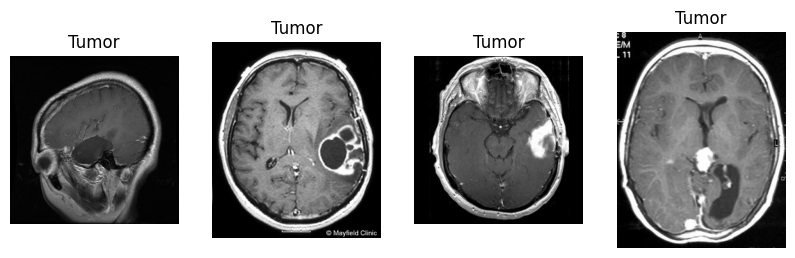

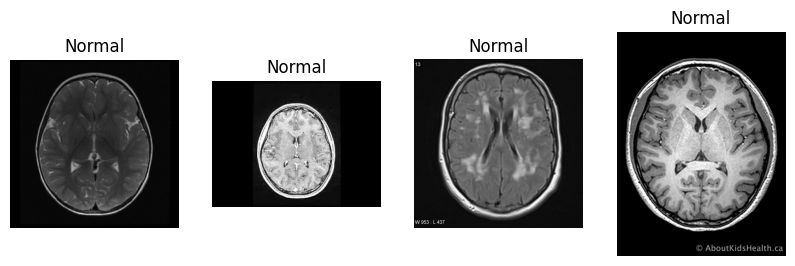

In [3]:
# Displaying Brain Tumor Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Brain Tumor/' + image_files_tumor[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Tumor')
plt.show()

# Displaying Normal Brain Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Healthy/' + image_files_normal[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Normal')
    
plt.show()

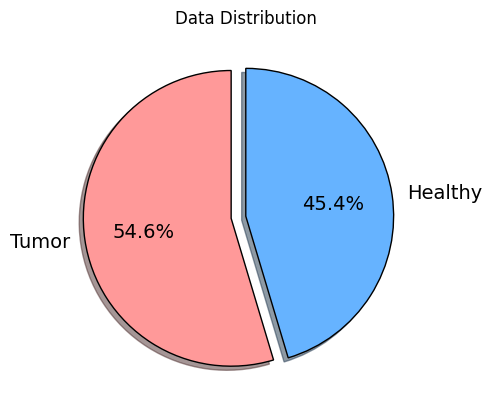

In [4]:
# visualizing the data distribution
data = {'Tumor': len(image_files_tumor), 'Healthy': len(image_files_normal)}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots()
ax.pie(values, labels=names, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0), shadow=True, textprops={'fontsize': 14}, wedgeprops={'edgecolor': 'black'})
ax.set_title('Data Distribution')
plt.show()

In [5]:
url_tumor = 'Brain Tumor Data Set/Brain Tumor/'
url_healthy = 'Brain Tumor Data Set/Healthy/'

# Merging the data
data = []
data_gray = []
for file in image_files_tumor:
    # save the image and the label (1 for tumor)
    img = cv2.imread(url_tumor + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 1]) # 1 for tumor
    data_gray.append([grayscale_image, 1])
  
for file in image_files_normal:
    img = cv2.imread(url_healthy + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 0]) # 0 for normal
    data_gray.append([grayscale_image, 0])
    
# Creating a DataFrame
df = pd.DataFrame(data, columns=['image', 'label'])

# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)


In [6]:
df_gray =  pd.DataFrame(data_gray, columns=['image', 'label'])
df_gray = df_gray.sample(frac=1).reset_index(drop=True)

In [7]:
df_gray.head()

,image,label
0,"[[14, 16, 16, 15, 14, 15, 14, 13, 13, 13, 12, ...",0
1,"[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,...",1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [8]:
df.head(10)

,image,label
0,"[[[19, 19, 19], [19, 19, 19], [19, 19, 19], [1...",0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[184, 184, 184], [169, 169, 169], [165, 165,...",1
3,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",1
4,"[[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4], ...",0
5,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",1
6,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",1
7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
8,"[[[49, 48, 44], [49, 48, 44], [50, 49, 45], [5...",1
9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0


In [9]:
# We have a meta data file that contains more information about the images

# Load the meta data
meta_data = pd.read_csv('metadata.csv', index_col=0)
meta_data.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


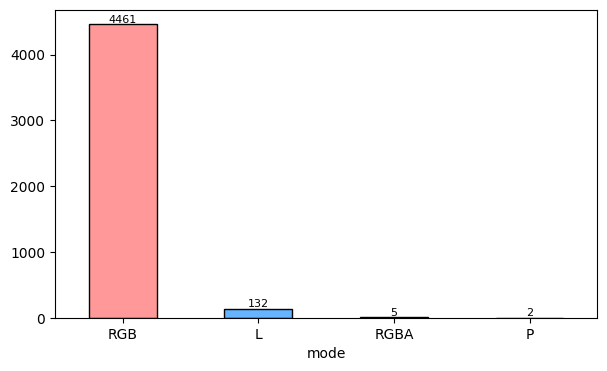

In [10]:
meta_data['mode'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff', '#ff55','#66b344'], rot=0, figsize=(7, 4), edgecolor='black')
for i, v in enumerate(meta_data['mode'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.show()

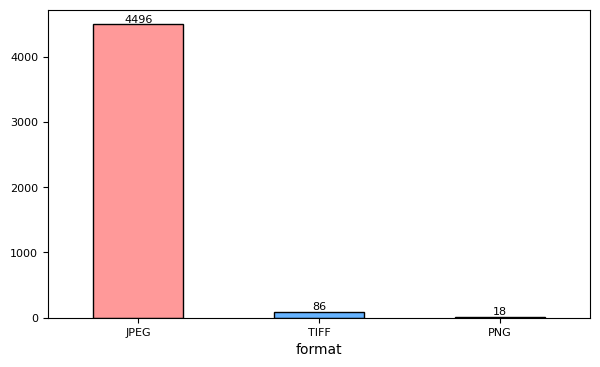

In [11]:
meta_data['format'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99'], figsize=(7, 4), edgecolor='black', fontsize=8, rot=0)
for i, v in enumerate(meta_data['format'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)


#### Step 1: Train and Test the model with RGB images

In [12]:
# Split the data
X = df['image'].values
y = df['label'].values

In [13]:
# Normalizing the data
X = X/ 255

In [14]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [16]:
# Flatten the image data
X_train_flat = np.array([x.flatten() for x in X_train])
X_val_flat = np.array([x.flatten() for x in X_val])

#### XGBoost model

In [ ]:
# Create the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Train the model without hyperparameter tuning
model.fit(X_train_flat, y_train)

# Make predictions
y_pred = model.predict(X_val_flat)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Initial Accuracy: {accuracy:.4f}')

# Perform hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 300)
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, scoring='accuracy', cv=3, n_jobs=-1, random_state=42, verbose=True)
random_search.fit(X_train_flat, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best accuracy: {random_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val_flat)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy with best model: {accuracy:.4f}')


Initial Accuracy: 0.9633
Fitting 3 folds for each of 1 candidates, totalling 3 fits


#### Random Forest Model


In [19]:
# Create the Random Forest model with predefined parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_flat, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_flat)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')

Random Forest Validation Accuracy: 0.9592


In [23]:
# Perform hyperparameter tuning with RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(range(10, 31, 10)),
    'min_samples_split': randint(2, 11)
}

random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=2, scoring='accuracy', cv=2, random_state=42, n_jobs=-1,verbose=True)
random_search_rf.fit(X_train_flat, y_train)

# Print the best parameters and the best score
print(f"Random Forest Best parameters: {random_search_rf.best_params_}")
print(f"Random Forest Best accuracy: {random_search_rf.best_score_:.4f}")

# Use the best model to make predictions
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_val_flat)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy with best model: {accuracy_rf:.4f}')


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Random Forest Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 192}
Random Forest Best accuracy: 0.9185
Random Forest Validation Accuracy with best model: 0.9606


#### Principal Component Analysis (PCA)

In [18]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
rf_model.fit(X_train_pca, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_pca)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy with PCA: {accuracy_rf:.4f}')

Random Forest Validation Accuracy with PCA: 0.9647


##### Vizualizing the images after PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08659082866184711..1.014896700045179].


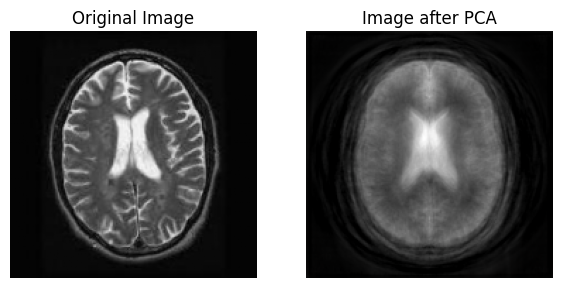

In [23]:

fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].imshow(X_train_flat[8].reshape(175, 175, 3))
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(pca.inverse_transform(X_train_pca[8]).reshape(175, 175, 3))
ax[1].axis('off')
ax[1].set_title('Image after PCA')

plt.show()


#### Train models with grayscale images

In [24]:
X_gray = df_gray['image'].values
y_gray = df_gray['label'].values

# Normalizing the data
X_gray = X_gray/ 255

# Splitting the data into training and testing sets
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(X_gray, y_gray, test_size=0.2, random_state=42, stratify=y_gray)

# Splitting the data into training and validation sets
X_train_gray, X_val_gray, y_train_gray, y_val_gray = train_test_split(X_train_gray, y_train_gray, test_size=0.2, random_state=42, stratify=y_train_gray)

# Flatten the image data
X_train_flat_gray = np.array([x.flatten() for x in X_train_gray])
X_val_flat_gray = np.array([x.flatten() for x in X_val_gray])


In [25]:
# Create the XGBoost model
model_gray = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Train the model without hyperparameter tuning
model_gray.fit(X_train_flat_gray, y_train_gray)

# Make predictions
y_pred_gray = model_gray.predict(X_val_flat_gray)

# Evaluate the model
accuracy_gray = accuracy_score(y_val_gray, y_pred_gray)

print(f'Initial Accuracy with grayscale images: {accuracy_gray:.4f}')

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Initial Accuracy with grayscale images: 0.9579


In [26]:
# save the xgboost model
joblib.dump(model_gray, 'xgboost_gray_model.pkl')

['xgboost_gray_model.pkl']